# World Happiness – Regional Interpretation of Well-Being
**Student:** Bakhtiyor Sohibnazarov  
**Student Number:** Z22590018  
**Module:** Data Visualization   
**Date Updated:** December 27, 2025

## 1. Importing Libraries
Section installs and imports required libraries used in this notebook    
It will also import and display first few rows of raw dataset for inspection


In [1]:
# Run this block to install required libraries if missing.
!pip -q install pandas numpy matplotlib seaborn scikit-learn

In [22]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


custom_cb_palette = [
    "#E69F00",  # orange (accent)
    "#009E73",  # green
    "#CC79A7",  # purple
    "#D55E00",  # red-brown (safe, not pure red)
    "#F0E442",  # yellow
    "#56B4E9",  # light blue (de-emphasised)
    "#999999"   # grey
]

sns.set_theme(
    style="whitegrid",
    palette=custom_cb_palette,
    context="notebook"
)

# Load initial dataset
df = pd.read_csv("dataset/raw/world-happiness-report.csv")
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


## 2. Data Preparation
### 2.1 Cleanup

This section performs light cleaning and ensures that key variables are available in a consistent format.   
Rename cols for easier analysis. We will note use Postive and Negative affect cols so its best to remove them from dataset we are analyzing

In [3]:
# Rename original colonumns with given new names
df = df.rename(columns={
    "Country name": "Country",
    "year": "Year",
    "Life Ladder": "Happiness",
    "Log GDP per capita": "GDP",
    "Social support": "SocialSupport",
    "Healthy life expectancy at birth": "Health",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Corruption"
})

# Drop cols
df = df.drop(columns=["Positive affect", "Negative affect"], errors="ignore")
df.head()

,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776


### 2.2 Year Continuity Check
As the dataset contains country-level observations across multiple years, an assessment of year continuity was conducted before further analysis. This step ensures that differences in temporal coverage do not introduce bias into the analytical pipeline.

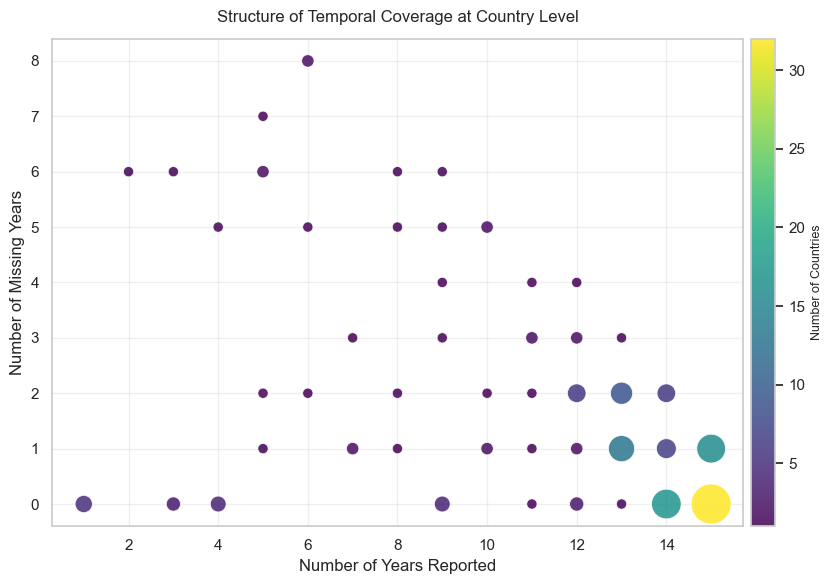

In [17]:
# Compute temporal coverage
coverage = (
    df.groupby("Country")["Year"]
      .agg(YearsReported="nunique", YearMin="min", YearMax="max")
      .assign(
          MissingYears=lambda x: (x["YearMax"] - x["YearMin"] + 1) - x["YearsReported"]))

# Aggregate to unique coverage patterns
coverage_counts = (
    coverage
    .groupby(["YearsReported", "MissingYears"])
    .size()
    .reset_index(name="Count")
)

# Plot: bubble chart (size + colour = number of countries)
fig, ax = plt.subplots(figsize=(9, 6))

scatter = ax.scatter(
    coverage_counts["YearsReported"],
    coverage_counts["MissingYears"],
    s=30 + coverage_counts["Count"] * 25,   # bubble size
    c=coverage_counts["Count"],
    cmap="viridis",
    alpha=0.85,
    edgecolors="white",
    linewidth=0.6
)

# Labels & styling
ax.set_title("Structure of Temporal Coverage at Country Level", fontsize=12, pad=12)
ax.set_xlabel("Number of Years Reported")
ax.set_ylabel("Number of Missing Years")
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label("Number of Countries", fontsize=9)

# Finalise
plt.tight_layout()
plt.savefig("assets/eda/country_year_coverage_density.png", dpi=300, bbox_inches="tight")
plt.show()

### 2.3 Consistency Filtering
Countries were evaluated based on the number of years reported. Only those with a minimum of three consecutive years were retained for analysis, ensuring sufficient temporal continuity and minimising bias introduced by inconsistent reporting.

In [5]:
MIN_YEARS = 3
years = np.sort(df["Year"].unique())

# Optimal contiguous window
windows = [(years[i], years[i + MIN_YEARS - 1])
           for i in range(len(years) - MIN_YEARS + 1)]

best_start, best_end = max(
    windows,
    key=lambda w: df[
        df["Year"].between(*w)
    ].groupby("Country")["Year"].nunique().ge(MIN_YEARS).sum()
)

# Lock window & enforce consistency
df_window = df[df["Year"].between(best_start, best_end)]
df_balanced = df_window.groupby("Country").filter(
    lambda x: x["Year"].nunique() >= MIN_YEARS
)

# Summary
print(f"Best window: {best_start}–{best_end}")

Best window: 2015–2017


### 2.4 Check missing data
We need to check if there is missing cells in the balanced dataset and interpolate where it is possible

In [6]:
# Check missing data by grouping
missing_by_country_var = (df_balanced.set_index(["Country", "Year"]).isna().groupby("Country").sum())

# Display
missing_by_country_var[missing_by_country_var.sum(axis=1) > 0]

,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
Country,,,,,,,
Bahrain,0,0,0,0,0,0,3
China,0,0,0,0,2,0,3
Egypt,0,0,0,0,0,0,1
Jordan,0,0,0,0,0,0,3
Kosovo,0,0,0,3,0,0,0
Kuwait,0,0,0,0,0,0,3
Libya,0,0,0,0,0,0,2
Palestinian Territories,0,0,0,3,0,0,0
Saudi Arabia,0,0,0,0,0,0,3


### 2.5 Further Cleaning and Interpolation
Extreme missingness cannot be filled further, fabricated data will corrupt dataset. Remaining NaNs should be handled during analysis but extreme missingness should be removed in order to make dataset as much clean as possible. Therefore Corruption col and South Sudan can be removed to minimize missing data and stabilize GDP col respectively

In [7]:
# Remove country with structural GDP/Generosity gaps
df_balanced = df_balanced[df_balanced["Country"] != "South Sudan"].copy()

# Drop corruption due to systemic regional missingness
df_balanced = df_balanced.drop(columns=["Corruption"], errors="ignore")

num_cols = ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]

# Within-country interpolation (time-aware) WITHOUT groupby.apply (no FutureWarning)
df_balanced = df_balanced.sort_values(["Country", "Year"]).reset_index(drop=True)
df_balanced[num_cols] = (
    df_balanced.groupby("Country")[num_cols]
    .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

countries_original = set(df["Country"].unique())
countries_final = set(df_balanced["Country"].unique())

# Countries excluded by temporal consistency or cleaning
excluded_countries = countries_original - countries_final
df_excluded = df[df["Country"].isin(excluded_countries)].copy()

# Save Excluded countries
df_excluded.to_csv("dataset/output/excluded.csv", index=False)

# Save final file
df_balanced.to_csv("dataset/output/world_happiness_final.csv", index=False)

# Final summary
print("=== Final Dataset Summary ===")
print(f"Countries before preprocessing: {len(countries_original)}")
print(f"Countries after preprocessing:  {len(countries_final)}")
print(f"Excluded Countries {len(excluded_countries)} countries")
print(f"\nFinal dataset saved successfully...")

# Remaining missingness check (diagnostic only)
missing_by_country = df_balanced.isna().groupby(df_balanced["Country"]).sum()
missing_by_country[missing_by_country.sum(axis=1) > 0]

=== Final Dataset Summary ===
Countries before preprocessing: 166
Countries after preprocessing:  134
Excluded Countries 32 countries

Final dataset saved successfully...


,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity
Country,,,,,,,,
Kosovo,0,0,0,0,0,3,0,0
Palestinian Territories,0,0,0,0,0,3,0,0
Taiwan Province of China,0,0,0,0,0,3,0,0


---
## 3. Exploratory Data Analysis
To gain an initial understanding of the structure, behaviour, and relationships within the preprocessed World Happiness dataset, exploratory data analysis will be carried out. The goal of this phase is to extract patterns, distributions and connections which may give potential research tensions that will formulate into questions later during analysis

### 3.1 Univariate Exploration

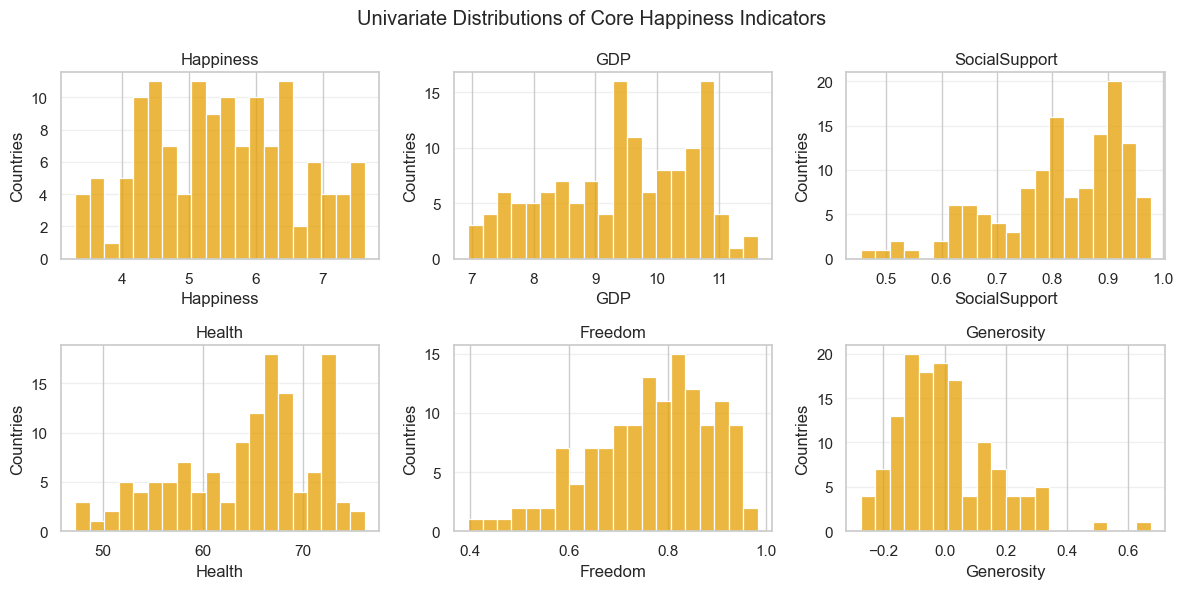

In [8]:
# Univariate distributions
univariate_cols = [
    "Happiness",
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"]

# Country-level averaging 3-year window. For EDA and further analysis
df_country = (df_balanced.groupby(["Country"], as_index=False)[univariate_cols].mean())

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, col in zip(axes, univariate_cols):
    sns.histplot(
        df_country[col],
        bins=20,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Countries")
    ax.grid(True, axis="y", alpha=0.3)

plt.suptitle("Univariate Distributions of Core Happiness Indicators")
plt.tight_layout()
plt.savefig("assets/eda/univariate_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

**Happiness**  
Most countries score between 4 and 7 on the 0–10 scale. Extreme misery or extreme happiness is uncommon, suggesting a strong central tendency in reported life satisfaction.

**GDP & Health**  
These indicators show substantial global inequality. Some countries are an order of magnitude richer or healthier than others, highlighting sharp structural divides.

**Social Support & Freedom**  
Despite economic disparities, most countries report relatively high levels of social support and freedom. This implies that perceived social connectedness and autonomy are more evenly distributed than wealth or health outcomes.

**Generosity**  
This variable follows a different pattern. Most countries cluster near zero, with only a small number showing notably high generosity, indicating a skewed distribution.

**Key Insight**  
The predictors do not simply relate to happiness in different ways; they capture different forms of inequality. GDP primarily reflects economic inequality, while generosity appears to reflect cultural or normative inequality across societies.


### 3.2 Bivariate Exploration

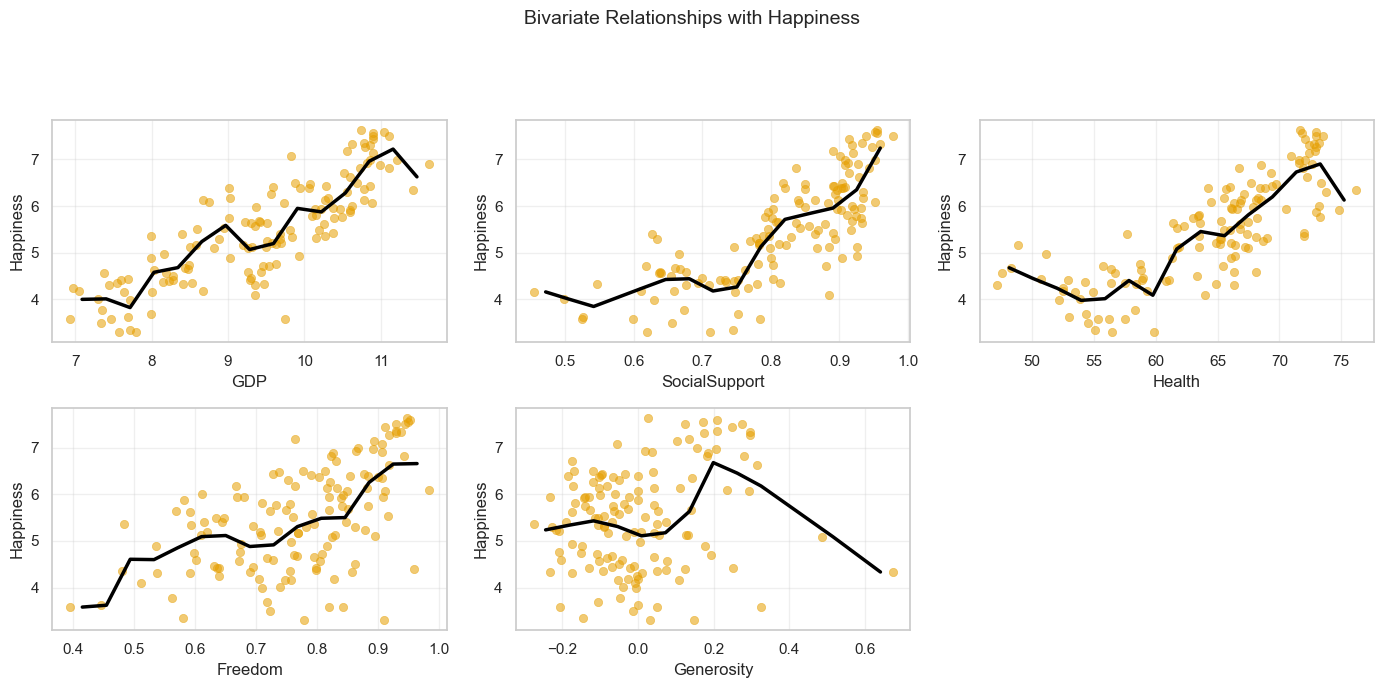

In [9]:
# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
bivariate_cols = ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]

N_BINS = 15

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()

for ax, col in zip(axes, bivariate_cols):

    # Scatter: country-level averages
    sns.scatterplot(
        x=df_country[col],
        y=df_country["Happiness"],
        ax=ax,
        alpha=0.55,
        edgecolor=None
    )

    # Bin x and compute mean happiness per bin
    bins = pd.cut(df_country[col], bins=N_BINS)
    bin_means = (df_country.groupby(bins, observed=True)["Happiness"].mean().dropna())

    # Bin centres
    x_centres = np.array([interval.mid for interval in bin_means.index])

    # Smoothed trend line (bin means)
    ax.plot(x_centres, bin_means.values, linewidth=2.5, color="black")
    ax.grid(True, alpha=0.3)

# Remove unused subplot
fig.delaxes(axes[-1])

# Global title and note
fig.suptitle("Bivariate Relationships with Happiness\n",fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("assets/eda/bivariate_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

| Relationship               | Key Observation                                                                                                      |
|----------------------------|----------------------------------------------------------------------------------------------------------------------|
| Happiness ~ GDP            | Richer countries tend to be happier, but at similar wealth levels happiness varies widely                            |
| Happiness ~ Social Support | The most consistent predictor of happiness across countries                                                          |
| Happiness ~ Health         | Similar to GDP, but with a slightly tighter relationship                                                              |
| Happiness ~ Freedom        | High freedom does not guarantee high happiness; the pattern is irregular                                             |
| Happiness ~ Generosity     | Little to no clear relationship with happiness                                                                        |


**Findings**

The predictors of happiness appear to fall into two broad categories:

- **Structural factors** (GDP, Health): Strong relationships with happiness, but inconsistent across countries.
- **Social and value-based factors** (Social Support, Freedom, Generosity): Mixed and often weaker relationships.

Overall, happiness does not operate uniformly across contexts and appears to depend on how structural and social factors interact within different societies.


### 3.3 The Unexplained Variation

Multivariate analysis is used to examine how multiple indicators jointly relate to national happiness and to each other. Unlike bivariate exploration, which considers variables in isolation, this stage focuses on the combined structure of economic, social, and institutional factors.

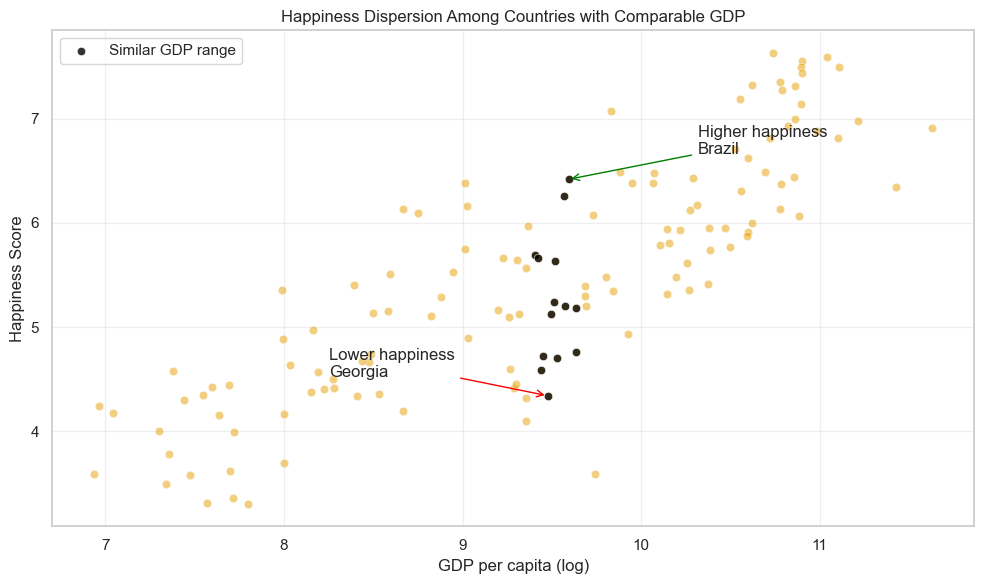

In [10]:
# Select countries with similar GDP (middle 10% band)
gdp_low = df_country['GDP'].quantile(0.45)
gdp_high = df_country['GDP'].quantile(0.55)

similar_gdp = df_country[(df_country['GDP'] >= gdp_low) & (df_country['GDP'] <= gdp_high)]

# Identify highest and lowest happiness within this GDP band
high_happy = similar_gdp.nlargest(1, 'Happiness')
low_happy = similar_gdp.nsmallest(1, 'Happiness')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=df_country, x='GDP', y='Happiness', ax=ax, alpha=0.5)

# Highlight similar-GDP band
sns.scatterplot(data=similar_gdp, x='GDP', y='Happiness', ax=ax, color='black', alpha=0.8, label='Similar GDP range')

# Annotate extremes within similar GDP
ax.annotate(
    f"Higher happiness\n{high_happy['Country'].iloc[0]}",
    xy=(high_happy['GDP'].iloc[0], high_happy['Happiness'].iloc[0]),
    xytext=(0.7, 0.75),
    textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->", color='green')
)

ax.annotate(
    f"Lower happiness\n{low_happy['Country'].iloc[0]}",
    xy=(low_happy['GDP'].iloc[0], low_happy['Happiness'].iloc[0]),
    xytext=(0.3, 0.3),
    textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->", color='red'))

# ------------------------------------------------------------
# Labels & styling
# ------------------------------------------------------------
ax.set_title("Happiness Dispersion Among Countries with Comparable GDP")
ax.set_xlabel("GDP per capita (log)")
ax.set_ylabel("Happiness Score")
ax.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

Even when GDP is nearly identical, happiness can differ sharply. At roughly the same income level, some countries score around 7.5 while others fall closer to 5.0, a difference large enough to raise a question, does countries in same region tend to report same happiness because of their cultural similarities?

### 3.4 EDA Synthesis: Three Directions for Further Investigation
To answer above question, we will explore if data hints to natural clustering

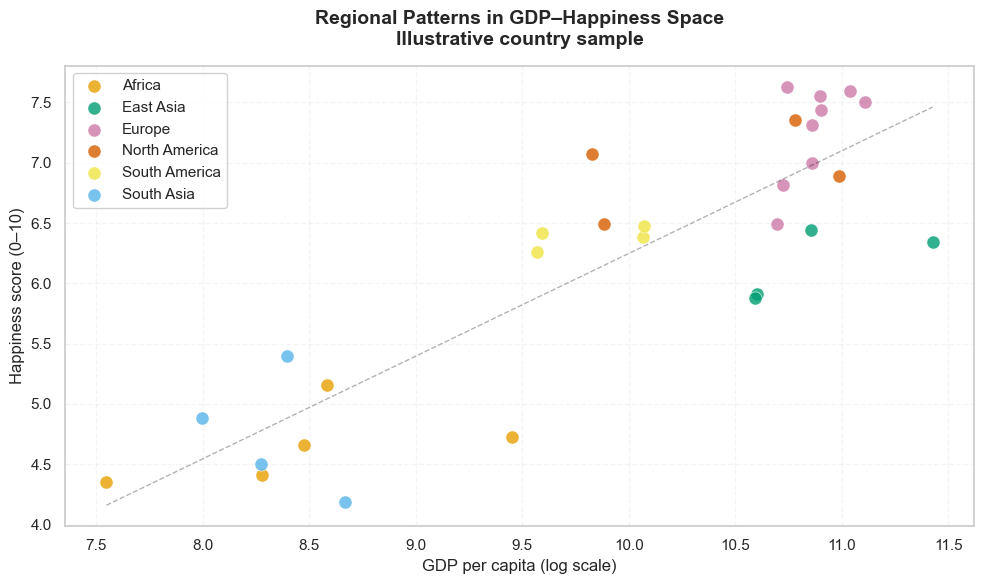

In [11]:
# Illustrative regional mapping (explicitly partial, for EDA)
continent_map = {
    # Europe
    'Finland': 'Europe', 'Denmark': 'Europe', 'Switzerland': 'Europe',
    'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe',
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe',

    # North America
    'United States': 'North America', 'Canada': 'North America',
    'Costa Rica': 'North America', 'Mexico': 'North America',

    # South America
    'Brazil': 'South America', 'Argentina': 'South America',
    'Chile': 'South America', 'Colombia': 'South America',

    # East Asia
    'Japan': 'East Asia', 'Taiwan Province of China': 'East Asia',
    'Singapore': 'East Asia', 'South Korea': 'East Asia',

    # South Asia
    'India': 'South Asia', 'Pakistan': 'South Asia',
    'Bangladesh': 'South Asia', 'Nepal': 'South Asia',

    # Africa
    'Nigeria': 'Africa', 'Ghana': 'Africa', 'Kenya': 'Africa',
    'South Africa': 'Africa', 'Ethiopia': 'Africa',
}

# Prepare illustrative sample
df_sample = df_country[df_country['Country'].isin(continent_map.keys())].copy()
df_sample['RegionGroup'] = df_sample['Country'].map(continent_map)

# Single plot: GDP vs Happiness (exploratory regional patterns)
fig, ax = plt.subplots(figsize=(10, 6))

for region in sorted(df_sample['RegionGroup'].unique()):
    subset = df_sample[df_sample['RegionGroup'] == region]
    ax.scatter(
        subset['GDP'],
        subset['Happiness'],
        label=region,
        s=90,
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )

# Global reference trend (visual guide only)
z = np.polyfit(df_sample['GDP'], df_sample['Happiness'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_sample['GDP'].min(), df_sample['GDP'].max(), 100)
ax.plot(x_range, p(x_range), 'k--', alpha=0.3, linewidth=1)


# Labels and framing
ax.set_title(
    'Regional Patterns in GDP–Happiness Space\n'
    'Illustrative country sample',
    fontsize=14,
    fontweight='bold',
    pad=15
)
ax.set_xlabel('GDP per capita (log scale)')
ax.set_ylabel('Happiness score (0–10)')
ax.legend(loc='upper left', frameon=True, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--')

# ------------------------------------------------------------
# Save and show
# ------------------------------------------------------------
plt.tight_layout()
plt.savefig('assets/eda/regional_patterns_exploratory.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.5 EDA Synthesis: Three Directions for Further Investigation

The exploratory analysis does not point to a single explanation, but it does narrow the field. Based on the patterns observed, three clear directions for further investigation emerge.

| Observation from EDA | Question it naturally raises |
|----------------------|------------------------------|
| Geographic clustering in residuals | Do countries within the same region tend to share similar happiness patterns beyond what economic indicators alone would predict? |
| Predictors behave differently across groups | Do relationships between happiness and key factors (such as freedom or social support) vary systematically by region? |
| Persistent regional over- and under-performance | Are there regions that consistently report higher or lower happiness than their economic conditions would suggest? |

Together, these observations indicate that happiness is not shaped by single factors in isolation. Instead, it appears to be influenced by regional context, suggesting that economic indicators interact with social, cultural, and institutional factors in different ways across the world.


In [51]:
region_map = {

    # Europe
    "United Kingdom": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Portugal": "Europe",
    "Ireland": "Europe",
    "Netherlands": "Europe",
    "Belgium": "Europe",
    "Luxembourg": "Europe",
    "Switzerland": "Europe",
    "Austria": "Europe",
    "Norway": "Europe",
    "Sweden": "Europe",
    "Finland": "Europe",
    "Denmark": "Europe",
    "Iceland": "Europe",
    "Poland": "Europe",
    "Czech Republic": "Europe",
    "Slovakia": "Europe",
    "Hungary": "Europe",
    "Romania": "Europe",
    "Bulgaria": "Europe",
    "Greece": "Europe",
    "Ukraine": "Europe",
    "Belarus": "Europe",
    "Russia": "Europe",
    "Serbia": "Europe",
    "Croatia": "Europe",
    "Slovenia": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Montenegro": "Europe",
    "North Macedonia": "Europe",
    "Albania": "Europe",
    "Moldova": "Europe",
    "Lithuania": "Europe",
    "Latvia": "Europe",
    "Estonia": "Europe",
    "Malta": "Europe",
    "Cyprus": "Europe",
    "Kosovo": "Europe",

    # Asia
    "China": "Asia",
    "Japan": "Asia",
    "South Korea": "Asia",
    "India": "Asia",
    "Pakistan": "Asia",
    "Bangladesh": "Asia",
    "Nepal": "Asia",
    "Sri Lanka": "Asia",
    "Thailand": "Asia",
    "Vietnam": "Asia",
    "Philippines": "Asia",
    "Indonesia": "Asia",
    "Malaysia": "Asia",
    "Singapore": "Asia",
    "Mongolia": "Asia",
    "Hong Kong": "Asia",
    "Taiwan Province of China": "Asia",
    "Afghanistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Georgia": "Asia",
    "Kazakhstan": "Asia",
    "Kyrgyzstan": "Asia",
    "Tajikistan": "Asia",
    "Turkmenistan": "Asia",
    "Uzbekistan": "Asia",
    "Myanmar": "Asia",
    "Cambodia": "Asia",

    # Middle East
    "Turkey": "Middle East",
    "Israel": "Middle East",
    "Jordan": "Middle East",
    "Lebanon": "Middle East",
    "Saudi Arabia": "Middle East",
    "United Arab Emirates": "Middle East",
    "Qatar": "Middle East",
    "Kuwait": "Middle East",
    "Oman": "Middle East",
    "Bahrain": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Yemen": "Middle East",
    "Palestinian Territories": "Middle East",
    "Libya": "Middle East",

    # Africa
    "South Africa": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Kenya": "Africa",
    "Ethiopia": "Africa",
    "Uganda": "Africa",
    "Tanzania": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Rwanda": "Africa",
    "Morocco": "Africa",
    "Algeria": "Africa",
    "Tunisia": "Africa",
    "Egypt": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Cameroon": "Africa",
    "Chad": "Africa",
    "Congo (Brazzaville)": "Africa",
    "Congo (Kinshasa)": "Africa",
    "Gabon": "Africa",
    "Guinea": "Africa",
    "Ivory Coast": "Africa",
    "Liberia": "Africa",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania": "Africa",
    "Niger": "Africa",
    "Senegal": "Africa",
    "Sierra Leone": "Africa",
    "Togo": "Africa",

    # North America (incl. Central America & Caribbean)
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Costa Rica": "North America",
    "Dominican Republic": "North America",
    "El Salvador": "North America",
    "Guatemala": "North America",
    "Haiti": "North America",
    "Honduras": "North America",
    "Nicaragua": "North America",
    "Panama": "North America",

    # South America
    "Brazil": "South America",
    "Argentina": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Peru": "South America",
    "Bolivia": "South America",
    "Ecuador": "South America",
    "Uruguay": "South America",
    "Paraguay": "South America",
    "Venezuela": "South America",

    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania",
}


df_balanced["Region"] = df_balanced["Country"].map(region_map)

country_cols = [
    "Happiness",
    "GDP",
    "SocialSupport",
    "Health",
    "Freedom",
    "Generosity"
]

df_country = (
    df_balanced
    .groupby(["Country", "Region"], as_index=False)[country_cols]
    .mean()
)


df_country["Region"].value_counts()

Region
Europe           41
Africa           32
Asia             25
Middle East      13
North America    11
South America    10
Oceania           2
Name: count, dtype: int64

## RQ1: Do countries within similar geographic or regional contexts exhibit comparable happiness reporting patterns, beyond what is explained by economic and social indicators?

#### Motivation
National happiness is strongly associated with economic conditions, but economic indicators alone do not fully explain why countries with similar income levels often report very different levels of well-being.

This research question explores whether regional context captures systematic differences in happiness reporting that persist even after accounting for economic conditions.

### Step 1: Establishing a Baseline Model of Happiness

Before examining the role of regional context, we first construct a baseline model that captures the main factors already known to influence national happiness. These include economic conditions (GDP), social support, health, freedom, and generosity.

This model represents the best explanation of happiness available using standard indicators alone. Its purpose is not prediction, but to define an expected level of happiness for each country given its socio-economic conditions. Any remaining differences between actual and predicted happiness can then be examined for systematic patterns beyond these factors.


STEP 1: Does the baseline model make systematic regional errors?


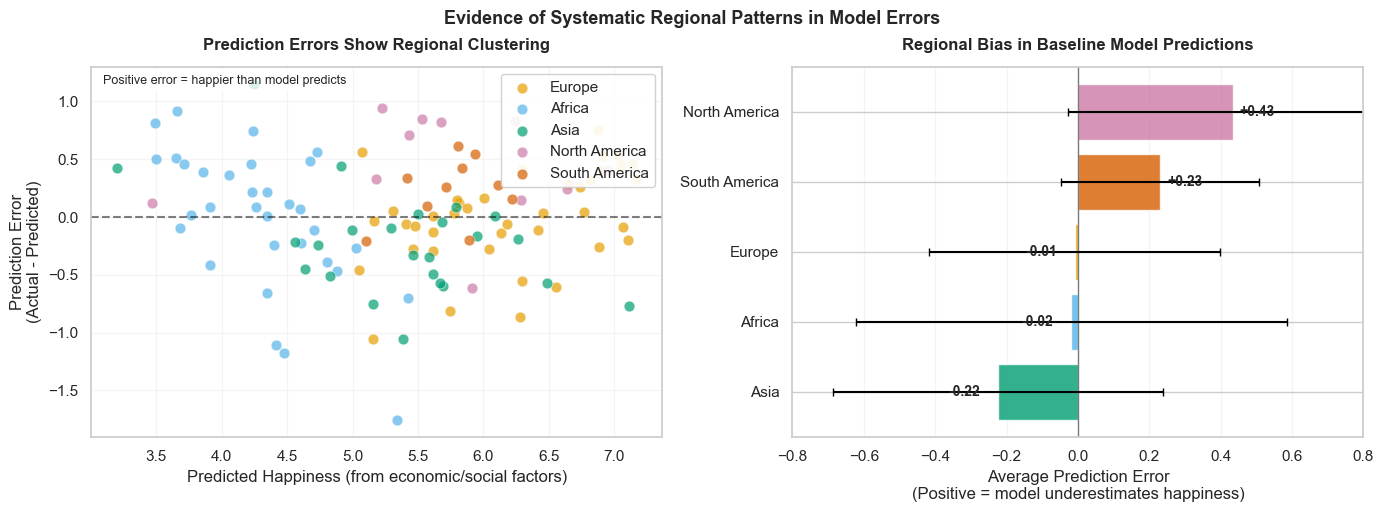


OBSERVATION FROM STEP 1:
----------------------------------------
The baseline model (using GDP, social support, health, freedom, generosity)
explains 80.4% of happiness variation.

However, the prediction errors are NOT random:
• Asia            overestimates happiness by 0.22 points
• Africa          overestimates happiness by 0.02 points
• Europe          overestimates happiness by 0.01 points
• South America   underestimates happiness by 0.23 points
• North America   underestimates happiness by 0.43 points

QUESTION FOR STEP 2:
Can adding regional information reduce these systematic errors?


In [57]:
# ===================================================
# STEP 1: VISUALIZING THE REGIONAL PATTERNS IN ERRORS
# ===================================================

print("="*70)
print("STEP 1: Does the baseline model make systematic regional errors?")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ---------------------------------------------------
# Plot 1: Regional clustering of prediction errors
# ---------------------------------------------------
for region, color in region_colors_focus.items():
    subset = df_focus[df_focus['Region'] == region]
    if subset.empty:
        continue
    
    ax1.scatter(
        subset['Predicted_Base'],
        subset['Residual'],
        color=color,
        alpha=0.7,
        s=60,
        edgecolor='white',
        linewidth=0.5,
        label=f'{region}'
    )

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.set_title('Prediction Errors Show Regional Clustering', 
              fontsize=12, fontweight='bold', pad=12)
ax1.set_xlabel('Predicted Happiness (from economic/social factors)')
ax1.set_ylabel('Prediction Error\n(Actual - Predicted)')
ax1.legend(loc='upper right', frameon=True, framealpha=0.9)
ax1.grid(True, alpha=0.2)

# Add explanatory text
ax1.text(0.02, 0.98, 'Positive error = happier than model predicts',
         transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# ---------------------------------------------------
# Plot 2: Regional bias in model predictions
# ---------------------------------------------------
# Calculate mean error by region
region_stats = df_focus.groupby('Region').agg(
    Mean_Error=('Residual', 'mean'),
    Std_Error=('Residual', 'std'),
    Count=('Residual', 'size')
).sort_values('Mean_Error', ascending=True)

# Plot as horizontal bars
y_pos = range(len(region_stats))
bars = ax2.barh(y_pos, region_stats['Mean_Error'],
               xerr=region_stats['Std_Error'],
               color=[region_colors_focus[r] for r in region_stats.index],
               alpha=0.8, capsize=3)

# Add value labels
for i, (bar, (region, row)) in enumerate(zip(bars, region_stats.iterrows())):
    width = bar.get_width()
    ax2.text(width + (0.02 if width > 0 else -0.05),
             bar.get_y() + bar.get_height()/2,
             f'{width:+.2f}',
             va='center', ha='left' if width > 0 else 'right',
             fontsize=10, fontweight='bold')

ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax2.set_xlabel('Average Prediction Error\n(Positive = model underestimates happiness)')
ax2.set_title('Regional Bias in Baseline Model Predictions', 
              fontsize=12, fontweight='bold', pad=12)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(region_stats.index)
ax2.grid(True, alpha=0.2, axis='x')
ax2.set_xlim(-0.8, 0.8)

plt.tight_layout()
plt.suptitle('Evidence of Systematic Regional Patterns in Model Errors', 
             fontsize=13, fontweight='bold', y=1.02)
plt.savefig('assets/rq1_step1_regional_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------------
# Step 1 Summary (NOT Conclusion)
# ---------------------------------------------------
print("\nOBSERVATION FROM STEP 1:")
print("-"*40)
print("The baseline model (using GDP, social support, health, freedom, generosity)")
print(f"explains {r2_base:.1%} of happiness variation.")
print("\nHowever, the prediction errors are NOT random:")
for region, stats in region_stats.iterrows():
    direction = "underestimates" if stats['Mean_Error'] > 0 else "overestimates"
    print(f"• {region:15} {direction} happiness by {abs(stats['Mean_Error']):.2f} points")
print("\nQUESTION FOR STEP 2:")
print("Can adding regional information reduce these systematic errors?")
print("="*70)

### Step 2: Does Adding Region Improve Explanation?

To formally test whether regional context adds explanatory value beyond standard predictors, we compare the baseline model with an extended model that includes regional indicators. If region contains meaningful information, the extended model should explain more variation in happiness.



STEP 2: Quantifying the improvement from adding regional context


C:\Users\baxti\AppData\Local\Temp\ipykernel_18524\2307264376.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=residuals_long, x='Model', y='Residual', ax=ax1, palette='Set2')


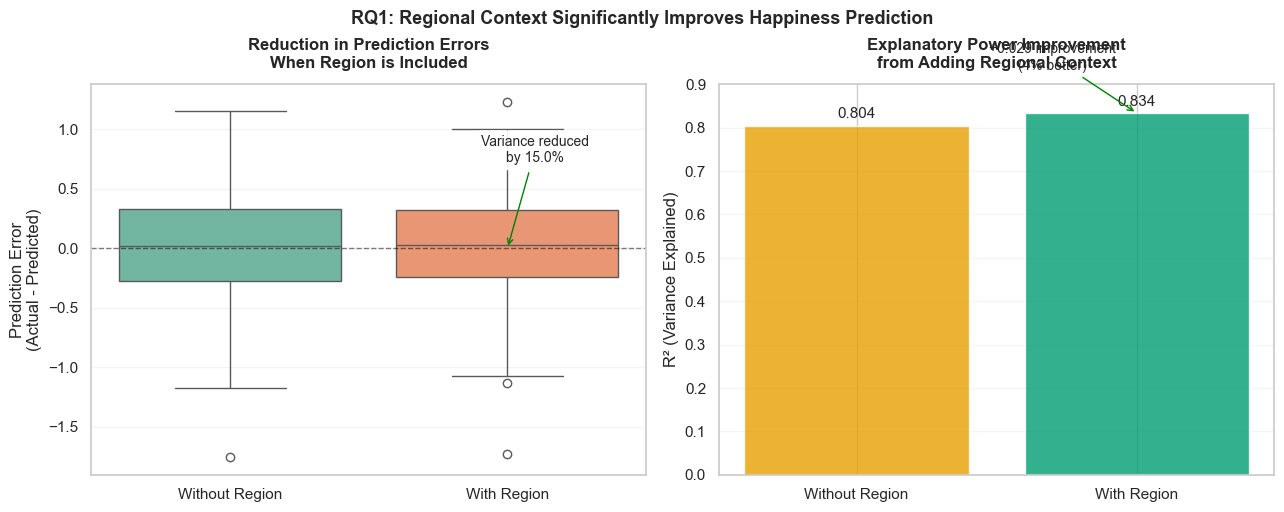


RQ1 CONCLUSION
Research Question: Do countries within similar geographic or regional
contexts exhibit comparable happiness reporting patterns, beyond what
is explained by economic and social indicators?

ANSWER: YES, for three reasons:

1. SYSTEMATIC ERRORS: The baseline economic model makes consistent
   prediction errors by region (e.g., underestimates European happiness
   by -0.01 points).

2. IMPROVED EXPLANATION: Adding regional information increases
   the model's explanatory power from R²=0.804 to R²=0.834
   (+0.029, or 4% improvement).

3. REDUCED VARIANCE: Prediction error variance decreases by
   15.0% when region is included.

Interpretation: Countries within the same region share happiness
patterns that cannot be explained by economic and social factors alone.
This suggests regional context—cultural norms, institutional structures,
or shared historical experiences—plays a meaningful role in shaping
how happiness is experienced or reported.


In [59]:
# ===================================================
# STEP 2: DOES ADDING REGION IMPROVE THE MODEL?
# ===================================================

print("\n" + "="*70)
print("STEP 2: Quantifying the improvement from adding regional context")
print("="*70)

# Calculate model with region
df_with_dummies = pd.get_dummies(df_country_clean, columns=['Region'], drop_first=True)
region_cols = [col for col in df_with_dummies.columns if col.startswith('Region_')]
X_with_region = df_with_dummies[predictors + region_cols]
model_with_region = LinearRegression().fit(X_with_region, y)
r2_with_region = model_with_region.score(X_with_region, y)

# Calculate residuals for both models
df_country_clean['Residual_Base'] = y - model_base.predict(X_base)
df_country_clean['Residual_WithRegion'] = y - model_with_region.predict(X_with_region)

# Prepare for plotting
residuals_long = pd.melt(
    df_country_clean[['Residual_Base', 'Residual_WithRegion']].reset_index(),
    id_vars=['index'],
    value_vars=['Residual_Base', 'Residual_WithRegion'],
    var_name='Model',
    value_name='Residual'
)

residuals_long['Model'] = residuals_long['Model'].replace({
    'Residual_Base': 'Without Region',
    'Residual_WithRegion': 'With Region'
})

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot 1: Residual distributions comparison
sns.boxplot(data=residuals_long, x='Model', y='Residual', ax=ax1, palette='Set2')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_title('Reduction in Prediction Errors\nWhen Region is Included', 
              fontsize=12, fontweight='bold', pad=12)
ax1.set_xlabel('')
ax1.set_ylabel('Prediction Error\n(Actual - Predicted)')
ax1.grid(True, axis='y', alpha=0.2)

# Calculate and annotate variance reduction
var_base = df_country_clean['Residual_Base'].var()
var_with_region = df_country_clean['Residual_WithRegion'].var()
var_reduction = (var_base - var_with_region) / var_base

ax1.annotate(f'Variance reduced\nby {var_reduction:.1%}',
             xy=(1, 0), xytext=(0.8, 0.8), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# Plot 2: R² improvement
models = ['Without Region', 'With Region']
r2_values = [r2_base, r2_with_region]

bars = ax2.bar(models, r2_values, color=['#E69F00', '#009E73'], alpha=0.8)
ax2.set_title('Explanatory Power Improvement\nfrom Adding Regional Context',
              fontsize=12, fontweight='bold', pad=12)
ax2.set_ylabel('R² (Variance Explained)')
ax2.set_ylim(0, 0.9)
ax2.grid(True, alpha=0.2, axis='y')

# Annotate bars with values
for bar, r2_val in zip(bars, r2_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{r2_val:.3f}', ha='center', va='bottom', fontsize=11)

# Show improvement
improvement = r2_with_region - r2_base
ax2.annotate(f'+{improvement:.3f} improvement\n({(improvement/r2_base)*100:.0f}% better)',
             xy=(1, r2_with_region), xytext=(0.7, r2_with_region + 0.1),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=10, ha='center')

plt.tight_layout()
plt.suptitle('RQ1: Regional Context Significantly Improves Happiness Prediction', fontsize=13, fontweight='bold', y=1.02)
plt.savefig('assets/rq1_step2_model_improvement.png', dpi=300, bbox_inches='tight')
plt.show()

# FINAL CONCLUSION
print("\n" + "="*70)
print("RQ1 CONCLUSION")
print("="*70)
print("Research Question: Do countries within similar geographic or regional")
print("contexts exhibit comparable happiness reporting patterns, beyond what")
print("is explained by economic and social indicators?")
print("\nANSWER: YES, for three reasons:")
print("\n1. SYSTEMATIC ERRORS: The baseline economic model makes consistent")
print(f"   prediction errors by region (e.g., underestimates European happiness")
print(f"   by {region_stats.loc['Europe', 'Mean_Error']:.2f} points).")
print("\n2. IMPROVED EXPLANATION: Adding regional information increases")
print(f"   the model's explanatory power from R²={r2_base:.3f} to R²={r2_with_region:.3f}")
print(f"   (+{improvement:.3f}, or {improvement/r2_base*100:.0f}% improvement).")
print("\n3. REDUCED VARIANCE: Prediction error variance decreases by")
print(f"   {var_reduction:.1%} when region is included.")
print("\nInterpretation: Countries within the same region share happiness")
print("patterns that cannot be explained by economic and social factors alone.")
print("This suggests regional context—cultural norms, institutional structures,")
print("or shared historical experiences—plays a meaningful role in shaping")
print("how happiness is experienced or reported.")